# BoXYZ - Segment Anybox



## Segement Anything 2 (SAM2) model

I'll use the [SAM2 model](). Some parts of the fine-tuning scripts are taken from [this datacamp tutorial](https://www.datacamp.com/tutorial/sam2-fine-tuning)

In [1]:
%cd ../models/segment-anything-2
# install may fail first time around. If it does, just run install again
!pip install --quiet -e .
cd ../

/media/abawi/Playground/PycharmProjects/clients/boxyz/models/segment-anything-2
^C

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
ERROR: Operation cancelled by user


In [5]:
%cd ../models/segment-anything-2
import os

import cv2
import torch
import torch.nn.utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
%cd sam2

/media/abawi/Playground/PycharmProjects/clients/boxyz/models/segment-anything-2
/media/abawi/Playground/PycharmProjects/clients/boxyz/models/segment-anything-2/sam2


### Chest CT dataset

#### Preprocessing

In [6]:
# IMP: this is actually a symbolic link to my data storage -> "segment-anything-2/datasets/"
data_dir = "../datasets/chest-ct-segmentation"
images_dir = os.path.join(data_dir, "images/images")
masks_dir = os.path.join(data_dir, "masks/masks")

train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_data = []
for index, row in train_df.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']
    
   train_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })

test_data = []
for index, row in test_df.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   test_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })

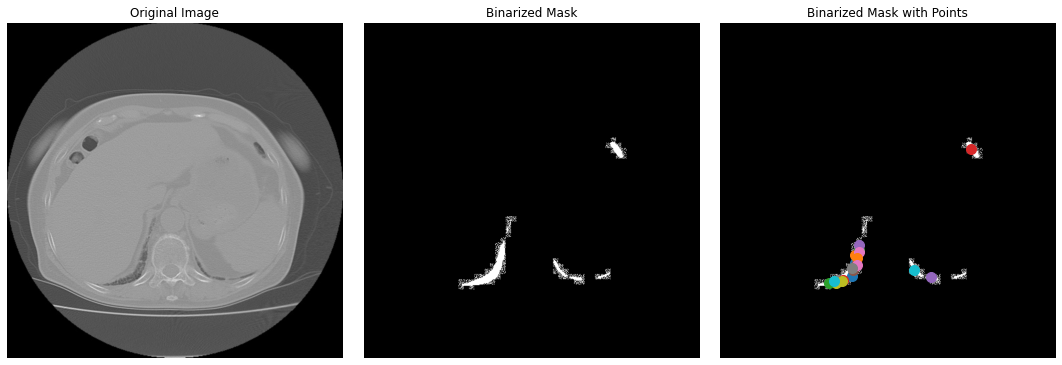

In [7]:
def read_batch(data, visualize_data=False):
   ent = data[np.random.randint(len(data))]

   img = cv2.imread(ent["image"])[..., ::-1]
   ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)

   if img is None or ann_map is None:
       print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
       return None, None, None, 0

   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])  # Scaling factor
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   
   # initialize a single binary mask
   binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
   points = []

   # get binary masks and combine them into a single mask
   inds = np.unique(ann_map)[1:]  # skip the background (index 0)
   for ind in inds:
       mask = (ann_map == ind).astype(np.uint8)  # create binary mask for each unique index
       binary_mask = np.maximum(binary_mask, mask)  # combine with the existing binary mask

   eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)
   coords = np.argwhere(eroded_mask > 0)
   if len(coords) > 0:
       for _ in inds:  # select as many points as there are unique labels
           yx = np.array(coords[np.random.randint(len(coords))])
           points.append([yx[1], yx[0]])

   points = np.array(points)
   
   if visualize_data:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # corrected to plot y, x order

        #plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

   binary_mask = np.expand_dims(binary_mask, axis=-1)
   binary_mask = binary_mask.transpose((2, 0, 1))
   points = np.expand_dims(points, axis=1)

   return img, binary_mask, points, len(inds)

img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

#### Fine-tuning setup

In [8]:
sam2_checkpoint = '../checkpoints/sam2.1_hiera_tiny.pt'  # @param ["sam2.1_hiera_tiny.pt", "sam2.1_hiera_small.pt", "sam2.1_hiera_base_plus.pt", "sam2.1_hiera_large.pt"]
model_cfg = 'configs/sam2.1/sam2.1_hiera_t.yaml' # @param ["sam2.1_hiera_t.yaml", "sam2.1_hiera_s.yaml", "sam2.1_hiera_b+.yaml", "sam2.1_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device='cuda')
predictor = SAM2ImagePredictor(sam2_model)

# configure to train decoder and prompt encoder only, since the image encoder needs a much better GPU than I have ATM
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)
# predictor.model.sam_image_encoder.train(False)
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5
scaler = torch.amp.GradScaler('cuda')  # mixed precision
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) #500 , 250, gamma = 0.1
accumulation_steps = 2  # number of steps to accumulate gradients before updating

NO_OF_STEPS = 3000
FINE_TUNED_MODEL_NAME = 'fine_tuned_chest_ct_sam2'

#### Fine-tuning start

In [11]:
for step in range(1, NO_OF_STEPS + 1):
   with torch.amp.autocast('cuda', dtype=torch.bfloat16):
       image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)
       if image is None or mask is None or num_masks == 0:
           continue

       input_label = np.ones((num_masks, 1))
       if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
           continue

       if input_point.size == 0 or input_label.size == 0:
           continue

       predictor.set_image(image)
       mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
       if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
           continue

       sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
       )

       batched_mode = unnorm_coords.shape[0] > 1
       high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features['high_res_feats']]
       low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
           image_embeddings=predictor._features['image_embed'][-1].unsqueeze(0),
           image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
           sparse_prompt_embeddings=sparse_embeddings,
           dense_prompt_embeddings=dense_embeddings,
           multimask_output=True,
           repeat_image=batched_mode,
           high_res_features=high_res_features,
       )
       prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

       gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
       prd_mask = torch.sigmoid(prd_masks[:, 0])
       seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

       inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
       iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
       loss = seg_loss + score_loss * 0.05

       # apply gradient accumulation
       loss = loss / accumulation_steps
       scaler.scale(loss).backward()

       # clip gradients
       torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

       scheduler.step()

       if step % accumulation_steps == 0:
           scaler.step(optimizer)
           scaler.update()
           predictor.model.zero_grad()

       if step % 500 == 0:
           FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + '_' + str(step) + '.torch'
           torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

       if step == 1:
           mean_iou = 0

       mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

       if step % 100 == 0:
           print('Step ' + str(step) + ':\t', 'Accuracy (IoU) = ', mean_iou)

/mnt/7A80B36880B32991/swap/micromamba/envs/lerobot/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.03 GiB. GPU 0 has a total capacity of 11.75 GiB of which 944.94 MiB is free. Including non-PyTorch memory, this process has 9.69 GiB memory in use. Of the allocated memory 8.07 GiB is allocated by PyTorch, and 1.31 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### Fine-tuning model inference

In [ ]:
# read and resize image and mask
def read_image(image_path, mask_path):  
   img = cv2.imread(image_path)[..., ::-1]
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

# sample points inside the input mask
def get_points(mask, num_points):
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']
image, mask = read_image(image_path, mask_path)

# generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(mask, num_samples)

FINE_TUNED_MODEL_WEIGHTS = f'{FINE_TUNED_MODEL_NAME}_1000.torch'
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device='cuda')

# build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # update occupancy_mask

# show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(seg_map, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()